<a href="https://colab.research.google.com/github/eyal-sasson/music-rnn/blob/main/MusicRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Generation with RNNs

In this notebook, we will build a Recurrent Neural Network (RNN) for music generation in the ABC notes format.

[![View Source on GitHub](https://badgen.net/badge/icon/View%20Source%20on%20GitHub?icon=github&label)](https://github.com/eyal-sasson/music-rnn/blob/main/MusicRNN.ipynb)

## 1. Dependencies 
We need to install and import some dependencies for the project.

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import time
import random
import regex as re
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display, Audio
from tqdm.notebook import tqdm, trange
from music21 import converter
from google.colab import files as gcfiles

!apt-get install timidity &> /dev/null

if len(tf.config.list_physical_devices('GPU')) == 0:
  print("You are not using a GPU. Consider switching for better performance.")

### Load utility functions

We need to create some functions play ABC notes in the notebook and to extract songs from a text.

In [ ]:
def play_abc(song):
  try:
    song_midi = converter.parse(song).write('midi')
    !timidity $song_midi -Ow -o tmp.wav --quiet=2
  except:
    return None
  return Audio('tmp.wav')

def extract_songs(text):
  pattern = '(^|\n\n)(.*?)\n\n'
  search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
  songs = [song[1] for song in search_results]
  print(f"Found {len(songs)} songs in text")
  return songs

## 2. Dataset

Upload the dataset as a zip file and unzip:

In [ ]:
uploaded = gcfiles.upload()
filename = list(uploaded.keys())[0]

Saving folkwiki.zip to folkwiki (1).zip


In [ ]:
!unzip $filename -d .

Archive:  folkwiki.zip
   creating: ./data/
  inflating: ./data/Gammal polska från Östmark.abc  
  inflating: ./data/Årsundavalsen.abc  
  inflating: ./data/ Bränd Jons polska.abc  
  inflating: ./data/ Bräklåt efter Kus-Erik.abc  
 extracting: ./data/ Älgpolskan.abc  
 extracting: ./data/Another Journey.abc  
 extracting: ./data/Barkarby brudmarsch.abc  
  inflating: ./data/Gånglåt från Hedemora.abc  
  inflating: ./data/(Brud-)Vals.abc  
  inflating: ./data/Anglais efter fadern.abc  
  inflating: ./data/Gånglåt från Storberget.abc  
  inflating: ./data/Funäsdalspolska efter Olle Thor.abc  
  inflating: ./data/Anglais efter Jularpa-Sven.abc  
  inflating: ./data/ Bingsjövalsen.abc  
  inflating: ./data/D-durspolska från Boda.abc  
 extracting: ./data/ Gevaliavalsen överstämma.abc  
  inflating: ./data/Älvrospolska i Am efter Anders Eriksson Moberg.abc  
  inflating: ./data/Den bruden blir aldrig jungfru mer.abc  
  inflating: ./data/Bergmanspolskan.abc  
  inflating: ./data/Beväringsm

List all the files and load the songs as strings:

In [ ]:
files = glob.glob("data/*.abc")
print("Number of files:", len(files))

Number of files: 1288


In [ ]:
songs = []
for file in files:
  with open(file) as f:
    songs.append(f.read())

print("Number of songs:", len(songs))

Number of songs: 1288


Choose a random song:

In [ ]:
sample_song = random.choice(songs)
print("Example song: ")
print(sample_song)

Example song: 
X:1
T:Julipolskan
M:3/4
L:1/8
K:D
|:"D"(3F2A2d2"A"(3e-ec|"G"(3d2B2G2"D"(3F-FA|"G"(3G-GB- (3Bde "D"(3agf|"Em"(3egf (3edB "A"A2|
"G"(3G2E2G2 "D"(3FED|"G"(3 B,DE (3FGA "Em"B2|"G"(3d-dB- (3Bgf "A"(3ece "To"+coda+|1"A" (3aef "D"d4:||2 "A"(3aef "D"d4-||
|:"Bm"(3d2d2B2 "A"(3cde|"D"f12/2-|"G"(3f2b2g2 "D"(3agf|"Em"(3e-eg (3fed "A"(3e-ec|"G"(3Bcd- (3dB-B "A"(3e-ec|
"D"(3deA- (3AB-B "G"(3G-GB|"D"(3 d2f2g2 "G"(3fed|1"A" (3ec-c "D"(d4:|2"A"(3ec-c "D"d4 "Da Capo"||
||+coda+(3a-a"Bm"d- (3dgf "A"(3 edA |"G"(3 B2d2a2 (3g-gf |"A"(3ec-c "D"d4||


Convert the song to audio and play it:

In [ ]:
play_abc(sample_song)

## 3. Process the dataset

### Join the songs to a single string
We will join the songs array to a long string, then get all unique characters in that string.

In [ ]:
songs_joined = "\n\n".join(songs)
vocab = sorted(set(songs_joined))
n_vocab = len(vocab)
print("There are", n_vocab, "unique characters in the dataset")

There are 110 unique characters in the dataset


### Vectorize the text

In order to train the model we're gonna have to feed it a numerical dataset. To do that, we have to convert our text to numbers. We'll create two maps to convert characters to numbers and vice versa.

In [ ]:
# Create a mapping from character to unique index.
# For example, to the index of the character "d"
# would be char2idx["d"].  
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
# the inverse of char2idx and allows us to convert back
# from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

Have a look at the first 20 chracters in our map:

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print(f'  {repr(char):4}: {char2idx[char]:3},')
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  '$' :   5,
  '%' :   6,
  '&' :   7,
  "'" :   8,
  '(' :   9,
  ')' :  10,
  '*' :  11,
  '+' :  12,
  ',' :  13,
  '-' :  14,
  '.' :  15,
  '/' :  16,
  '0' :  17,
  '1' :  18,
  '2' :  19,
  ...
}


Let's now convert all the songs to our vectorized representations.

In [ ]:
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

vectorized_songs = vectorize_string(songs_joined)

For example, here's how the first part of the text is mapped to an integer representation:

In [ ]:
print(f'{repr(songs_joined[:10])} ----> {vectorized_songs[:10]}')

'X:31\nT:Ham' ----> [56 27 20 18  0 52 27 40 63 75]


## 4. The RNN model

### Define the batching for the training examples

We now need to create training examples from our text. We will divide the string of vectorized songs into sequences of length `seq_length`.

For our model to predict the next character, we will need target sequences which will be the input sequences shifted one character to the right.

We do so for `batch_size` sequences and return 2d arrays containing the sequences for each batch.

In [ ]:
def get_batch(vectorized_songs, seq_length, batch_size):
  n = vectorized_songs.shape[0] - 1
  idx = np.random.choice(n-seq_length, batch_size) # random indices array of size [batch size] 

  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]

  # reshape the inputs and outputs to matrices having seq_length as the second coord
  x_batch = np.reshape(input_batch, [-1, seq_length])
  y_batch = np.reshape(output_batch, [-1, seq_length])
  return x_batch, y_batch

### Define the model

Our model consists of an `LSTM` layer with 512 units, then a `Dense` layer with `n_vocab` neurons.

In [ ]:
model = keras.Sequential([
  layers.LSTM(512,
    recurrent_initializer='he_normal',
    return_sequences=True, 
    recurrent_activation='sigmoid', input_shape=[None, 1]),
  layers.Dense(n_vocab, activation='softmax')
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, None, 512)         1052672   
                                                                 
 dense_7 (Dense)             (None, None, 110)         56430     
                                                                 
Total params: 1,109,102
Trainable params: 1,109,102
Non-trainable params: 0
_________________________________________________________________


### Compile the model
We are using the `SparseCategoricalCrossentropy` loss function and the `Adam` optimizer. Here, the learning rate is set to be `1e-3 = 0.001`, it should be changed and tweaks according to the data.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3))

## Training the model

First let's define the hyperparameters for our model: the sequence length and batch size to pass to our `get_batch` function and the number of steps our model will run for.

In [ ]:
seq_length = 300
batch_size = 64
training_steps = 8000

Now we can train the model!

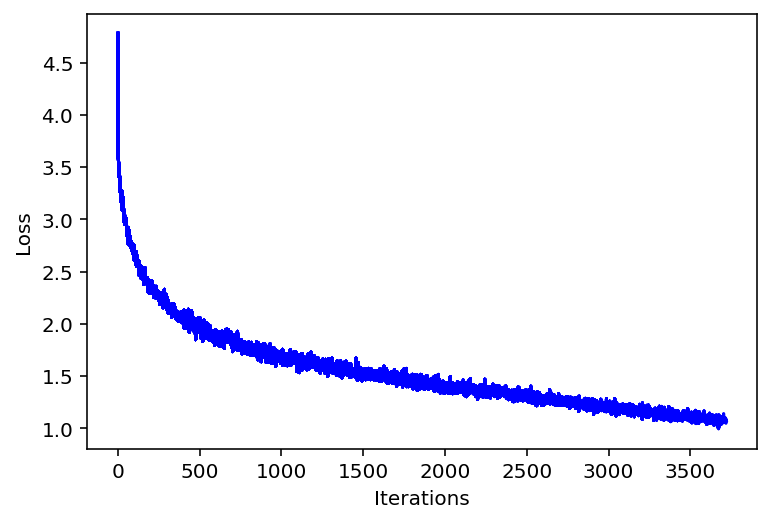

  0%|          | 0/8000 [00:00<?, ?it/s]

In [ ]:
history = []
fig = plt.figure()
hfig = display(fig, display_id=True)
plt.xlabel("Iterations")
plt.ylabel("Loss")

for i in (bar := trange(training_steps)):
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = model.train_on_batch(x_batch, y_batch)
  history.append(loss)
  bar.set_postfix_str(f"Loss: {loss}")
  if i % 30 == 0:
    plt.plot(history, color="blue")
    hfig.update(fig)
plt.close(fig)

We should save our model to a file so we can load it later and use it without needing to train it again.

In [ ]:
model.save(filename.replace('zip', 'h5'))

## Generating music!

First we will define the generation function: it receives the model itself, a starting string for the generation, and the desired generated string length.

In [ ]:
def generate_text(model, start_string, generation_length=1000):
  text = start_string
  bar = trange(generation_length)
  tqdm.write(f"Generated text:\n\n{text}", end="")

  for i in bar:
    input = tf.expand_dims([char2idx[s] for s in text], 0) # convert the string to a tensor
    predictions = model.predict(input, verbose=0) # pass the input to the model
    predicted_id = predictions[0, -1].argmax() # get the predicted character's id
    predicted_char = idx2char[predicted_id] # convert to a character
    text += idx2char[predicted_id] # append to the end of the text
    tqdm.write(predicted_char, end="")
    
  return text

In order to not get the same output every time, we will append a random seed to the start string.

In [ ]:
seed = random.randint(0, 100)
generated_text = generate_text(model, start_string=f"X:{seed}", generation_length=500)

  0%|          | 0/500 [00:00<?, ?it/s]

Generated text:

X:52
M:F
g2 |: ved}a2{c} cBB | (BB) A4 d | ed ed (3eff | (3fBc (3cAc B>G | 
G>E (3^Bc (3GAcG | (3ABc A2 z |] 
(3d/f/g/ g/g/g/ a>g | (3eff (3ede (3eAg | (3eAc (3cdB (3dcB | 
(3AcB (3f-ac | (3aBd (3cBc (3GGG | (3ABB [GA]4 |] 
(3(AGA) (3(AGB) (3(BGA) | (3(BBG) G2 z2 |] 
V:2
T:Barlals br Jora-Eriers Harg
L:1/16
M:2/4
K:D
V:1
|:"^1" (D>)cc f2e2 | (Bd)BA (GF)AB | (BB)AA (GF)DF | (AF)AF (DF)AF | (FF)FF (FF)DB | (AB)cA (FF)AF | (GA)GA (GA)Gc | 
(de)ec (Ac)AF |"G" (Bd)BG (GB)Bc | (BA)AB (AG)DG |1"G" (B,C,) B

Let's now play the generated songs!

In [ ]:
generated_songs = extract_songs(generated_text)

for i, song in enumerate(generated_songs):
  waveform = play_abc(song)

  if waveform:
    print("Generated song", i)
    display(waveform)

Found 0 songs in text


# Conclusion

We were able to create an RNN model that generates ABC notes, which can later be converted to actual audio!

This project took a fair amount of inspiration from [Lab 1 of the MIT Deep Learning Course](https://colab.research.google.com/github/aamini/introtodeeplearning/blob/2023/lab1/solutions/Part2_Music_Generation_Solution.ipynb).

In [ ]:
# Copyright 2023 MIT Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of MIT Introduction
# to Deep Learning must reference:
#
# © MIT Introduction to Deep Learning
# http://introtodeeplearning.com
#